In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option('display.max_columns', None)

In [2]:
# read data
data_for_model = pd.read_csv('Combined Station Data.csv')
#data_for_model.drop(columns=['anomaly'], inplace=True)
data_for_model

,Date,Wind,Wind Dir,SO2,NO2,NOX,PM10,PM2.5,Pressure,Temp,NO1,Date Time,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Chicken Farm,Location_Marapong,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend
0,2016/01/15 16:10:00,5.726794,101.24370,25.67,0.808,18.10,131.10,56.570,843.0,22.97,22.440,2016-01-15 16:10:00,16,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.726794,NaN,5.726794,NaN,5.726794,NaN,5.726794,NaN,101.243700,NaN,101.243700,NaN,101.243700,NaN,101.243700,NaN,25.670000,NaN,25.670000,NaN,25.670000,NaN,25.670000,NaN,0.808000,NaN,0.808000,NaN,0.808000,NaN,0.808000,NaN,18.100000,NaN,18.100000,NaN,18.100000,NaN,18.100000,NaN,131.100000,NaN,131.100000,NaN,131.100000,NaN,131.100000,NaN,56.570000,NaN,56.570000,NaN,56.570000,NaN,56.570000,NaN,843.000000,NaN,843.000000,NaN,843.000000,NaN,843.000000,NaN,22.970000,NaN,22.970000,NaN,22.970000,NaN,22.970000,NaN,22.440000,NaN,22.440000,NaN,22.440000,NaN,22.440000,NaN,True,False,False,False,False,True,False,True,False
1,2016/01/15 16:20:00,5.942719,101.66950,20.56,1.167,17.69,130.70,46.890,844.0,22.58,18.970,2016-01-15 16:20:00,16,1,4,5.726794,101.24370,25.67,0.808,18.10,131.10,56.570,843.0,22.97,22.440,5.834757,0.152682,5.834757,0.152682,5.834757,0.152682,5.834757,0.152682,101.456600,0.301086,101.456600,0.301086,101.456600,0.301086,101.456600,0.301086,23.115000,3.613316,23.115000,3.613316,23.115000,3.613316,23.115000,3.613316,0.987500,0.253851,0.987500,0.253851,0.987500,0.253851,0.987500,0.253851,17.895000,0.289914,17.895000,0.289914,17.895000,0.289914,17.895000,0.289914,130.900000,0.282843,130.900000,0.282843,130.900000,0.282843,130.900000,0.282843,51.730000,6.844794,51.730000,6.844794,51.730000,6.844794,51.730000,6.844794,843.500000,0.707107,843.500000,0.707107,843.500000,0.707107,843.500000,0.707107,22.775000,0.275772,22.775000,0.275772,22.775000,0.275772,22.775000,0.275772,20.705000,2.453661,20.705000,2.453661,20.705000,2.453661,20.705000,2.453661,True,False,False,False,False,True,False,True,False
2,2016/01/15 16:30:00,6.538234,94.81412,17.24,1.212,12.66,141.30,51.600,843.0,22.84,15.760,2016-01-15 16:30:00,16,1,4,5.942719,101.66950,20.56,1.167,17.69,130.70,46.890,844.0,22.58,18.970,6.069249,0.420257,6.069249,0.420257,6.069249,0.420257,6.069249,0.420257,99.242440,3.840943,99.242440,3.840943,99.242440,3.840943,99.242440,3.840943,21.156667,4.246555,21.156667,4.246555,21.156667,4.246555,21.156667,4.246555,1.062333,0.221405,1.062333,0.221405,1.062333,0.221405,1.062333,0.221405,16.150000,3.029373,16.150000,3.029373,16.150000,3.029373,16.150000,3.029373,13

In [3]:
# Shift the target by -24 to predict 24 hours ahead
data_for_model['PM2.5_t+6'] = data_for_model['PM2.5'].shift(-6)

# Drop rows with NaNs introduced by shifting
data_for_model = data_for_model.dropna(subset=['PM2.5_t+6'])

data_for_model

,Date,Wind,Wind Dir,SO2,NO2,NOX,PM10,PM2.5,Pressure,Temp,NO1,Date Time,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Chicken Farm,Location_Marapong,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,PM2.5_t+6
0,2016/01/15 16:10:00,5.726794,101.24370,25.67,0.808,18.10,131.10,56.570,843.0,22.97,22.44,2016-01-15 16:10:00,16,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.726794,NaN,5.726794,NaN,5.726794,NaN,5.726794,NaN,101.243700,NaN,101.243700,NaN,101.243700,NaN,101.243700,NaN,25.670000,NaN,25.670000,NaN,25.670000,NaN,25.670000,NaN,0.808000,NaN,0.808000,NaN,0.808000,NaN,0.808000,NaN,18.100000,NaN,18.100000,NaN,18.100000,NaN,18.100000,NaN,131.100000,NaN,131.100000,NaN,131.100000,NaN,131.100000,NaN,56.570000,NaN,56.570000,NaN,56.570000,NaN,56.570000,NaN,843.000000,NaN,843.000000,NaN,843.000000,NaN,843.000000,NaN,22.970000,NaN,22.970000,NaN,22.970000,NaN,22.970000,NaN,22.440000,NaN,22.440000,NaN,22.440000,NaN,22.440000,NaN,True,False,False,False,False,True,False,True,False,43.650
1,2016/01/15 16:20:00,5.942719,101.66950,20.56,1.167,17.69,130.70,46.890,844.0,22.58,18.97,2016-01-15 16:20:00,16,1,4,5.726794,101.24370,25.67,0.808,18.10,131.10,56.570,843.0,22.97,22.44,5.834757,0.152682,5.834757,0.152682,5.834757,0.152682,5.834757,0.152682,101.456600,0.301086,101.456600,0.301086,101.456600,0.301086,101.456600,0.301086,23.115000,3.613316,23.115000,3.613316,23.115000,3.613316,23.115000,3.613316,0.987500,0.253851,0.987500,0.253851,0.987500,0.253851,0.987500,0.253851,17.895000,0.289914,17.895000,0.289914,17.895000,0.289914,17.895000,0.289914,130.900000,0.282843,130.900000,0.282843,130.900000,0.282843,130.900000,0.282843,51.730000,6.844794,51.730000,6.844794,51.730000,6.844794,51.730000,6.844794,843.500000,0.707107,843.500000,0.707107,843.500000,0.707107,843.500000,0.707107,22.775000,0.275772,22.775000,0.275772,22.775000,0.275772,22.775000,0.275772,20.705000,2.453661,20.705000,2.453661,20.705000,2.453661,20.705000,2.453661,True,False,False,False,False,True,False,True,False,35.660
2,2016/01/15 16:30:00,6.538234,94.81412,17.24,1.212,12.66,141.30,51.600,843.0,22.84,15.76,2016-01-15 16:30:00,16,1,4,5.942719,101.66950,20.56,1.167,17.69,130.70,46.890,844.0,22.58,18.97,6.069249,0.420257,6.069249,0.420257,6.069249,0.420257,6.069249,0.420257,99.242440,3.840943,99.242440,3.840943,99.242440,3.840943,99.242440,3.840943,21.156667,4.246555,21.156667,4.246555,21.156667,4.246555,21.156667,4.246555,1.062333,0.221405,1.062333,0.221405,1.062333,0.221405,1.062333,0.221405,16.150000,3.029373,16.150000,3.029373,16.150000,3.029373,16

In [4]:
location_cols = [col for col in data_for_model.columns if col.startswith('Location_')]

def decode_location(row):
    for col in location_cols:
        if row[col] == 1:
            return col.replace('Location_', '')
    return 'Unknown'

data_for_model['Location'] = data_for_model.apply(decode_location, axis=1)


data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])
locations = data_for_model['Location'].unique()

C:\Users\Shivm\AppData\Local\Temp\ipykernel_10476\975132283.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['Location'] = data_for_model.apply(decode_location, axis=1)
C:\Users\Shivm\AppData\Local\Temp\ipykernel_10476\975132283.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])


In [5]:
features_to_keep = [
    'Hour', 'Month', 'DayOfWeek', 'Date Time',

    'Wind', 'Wind_lag1', 'Wind_roll3_mean', 'Wind_roll6_mean', 'Wind_roll12_mean', 'Wind_roll24_mean',
    'Pressure', 'Pressure_lag1', 'Pressure_roll3_mean', 'Pressure_roll6_mean', 'Pressure_roll12_mean', 'Pressure_roll24_mean',
    'Temp', 'Temp_lag1', 'Temp_roll3_mean', 'Temp_roll6_mean', 'Temp_roll12_mean', 'Temp_roll24_mean',
    
    'SO2', 'SO2_lag1', 'SO2_roll3_mean', 'SO2_roll6_mean', 'SO2_roll12_mean', 'SO2_roll24_mean',
    'NO2', 'NO2_lag1', 'NO2_roll3_mean', 'NO2_roll6_mean', 'NO2_roll12_mean', 'NO2_roll24_mean',
    'NOX', 'NOX_lag1', 'NOX_roll3_mean', 'NOX_roll6_mean', 'NOX_roll12_mean', 'NOX_roll24_mean',
    'PM10', 'PM10_lag1', 'PM10_roll3_mean', 'PM10_roll6_mean', 'PM10_roll12_mean', 'PM10_roll24_mean',
    'PM2.5', 'PM2.5_t+6', 'PM2.5_lag1', 'PM2.5_roll3_mean', 'PM2.5_roll6_mean', 'PM2.5_roll12_mean', 'PM2.5_roll24_mean',

    'Location_Chicken Farm', 'Location_Marapong', 'Location_Phola',  # if using one-hot
    'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',  # only if proven useful
]

data_for_model= data_for_model[features_to_keep]
data_for_model

,Hour,Month,DayOfWeek,Date Time,Wind,Wind_lag1,Wind_roll3_mean,Wind_roll6_mean,Wind_roll12_mean,Wind_roll24_mean,Pressure,Pressure_lag1,Pressure_roll3_mean,Pressure_roll6_mean,Pressure_roll12_mean,Pressure_roll24_mean,Temp,Temp_lag1,Temp_roll3_mean,Temp_roll6_mean,Temp_roll12_mean,Temp_roll24_mean,SO2,SO2_lag1,SO2_roll3_mean,SO2_roll6_mean,SO2_roll12_mean,SO2_roll24_mean,NO2,NO2_lag1,NO2_roll3_mean,NO2_roll6_mean,NO2_roll12_mean,NO2_roll24_mean,NOX,NOX_lag1,NOX_roll3_mean,NOX_roll6_mean,NOX_roll12_mean,NOX_roll24_mean,PM10,PM10_lag1,PM10_roll3_mean,PM10_roll6_mean,PM10_roll12_mean,PM10_roll24_mean,PM2.5,PM2.5_t+6,PM2.5_lag1,PM2.5_roll3_mean,PM2.5_roll6_mean,PM2.5_roll12_mean,PM2.5_roll24_mean,Location_Chicken Farm,Location_Marapong,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,16,1,4,2016-01-15 16:10:00,5.726794,NaN,5.726794,5.726794,5.726794,5.726794,843.0,NaN,843.000000,843.000000,843.000000,843.000000,22.97,NaN,22.970000,22.970000,22.970000,22.970000,25.67,NaN,25.670000,25.670000,25.670000,25.670000,0.808,NaN,0.808000,0.808000,0.808000,0.808000,18.10,NaN,18.100000,18.100000,18.100000,18.100000,131.10,NaN,131.100000,131.100000,131.100000,131.100000,56.570,43.650,NaN,56.570000,56.570000,56.570000,56.570000,True,False,False,False,False,True,False
1,16,1,4,2016-01-15 16:20:00,5.942719,5.726794,5.834757,5.834757,5.834757,5.834757,844.0,843.0,843.500000,843.500000,843.500000,843.500000,22.58,22.97,22.775000,22.775000,22.775000,22.775000,20.56,25.67,23.115000,23.115000,23.115000,23.115000,1.167,0.808,0.987500,0.987500,0.987500,0.987500,17.69,18.10,17.895000,17.895000,17.895000,17.895000,130.70,131.10,130.900000,130.900000,130.900000,130.900000,46.890,35.660,56.570,51.730000,51.730000,51.730000,51.730000,True,False,False,False,False,True,False
2,16,1,4,2016-01-15 16:30:00,6.538234,5.942719,6.069249,6.069249,6.069249,6.069249,843.0,844.0,843.333333,843.333333,843.333333,843.333333,22.84,22.58,22.796667,22.796667,22.796667,22.796667,17.24,20.56,21.156667,21.156667,21.156667,21.156667,1.212,1.167,1.062333,1.062333,1.062333,1.062333,12.66,17.69,16.150000,16.150000,16.150000,16.150000,141.30,130.70,134.366667,134.366667,134.366667,134.366667,51.600,30.970,46.890,51.686667,51.686667,51.686667,51.686667,True,False,False,False,False,True,False
3,16,1,4,2016-01-15 16:40:00,7.156286,6.538234,6.545746,6.341008,6.341008,6.341008,844.0,843.0,843.666667,843.500000,843.500000,843.500000,22.32,22.84,22.580000,22.677500,22.677500,22.677500,13.81,17.24,17.203333,19.320000,19.320000,19.320000,1.324,1.212,1.234333,1.127750,1.127750,1.127750,10.92,12.66,13.756667,14.842500,14.842500,14.842500,146.10,141.30,139.366667,137.300000,137.300000,137.300000,53.250,27.040,51.600,50.580000,52.077500,52.077500,52.077500,True,False,False,False,False,True,False
4,16,1,4,2016-01-15 16:50:00,6.355300,7.156286,6.683273,6.343867,6.343867,6.343867,844.0,844.0,843.666667,843.600000,843.600000,843.600000,21.94,22.32,22.366667,22.530000,22.530000,22.530000,9.97,13.81,13.673333,17.450000,17.450000,17.450000,1.302,1.324,1.279333,1.162600,1.162600,1.162600,13.42,10.92,12.333333,14.558000,14.558000,14.558000,146.40,146.10,144.600000,139.120000,139.120000,139.120000,51.610,32.590,53.250,52.153333,51.984000,51.984000,51.984000,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348620,13,2,1,2018-02-20 13:00:00,3.307337,3.527347,3.269607,2.682396,2.832595,2.597463,848.0,849.0,848.666667,848.833333,849.083333,849.541667,25.42,25.13,25.280000,24.928333,24.321667,23.451250,NaN,NaN,NaN,NaN,NaN,NaN,10.160,9.870,9.896667,9.481500,11.892417,13.869125,19.78,17.36,18.653333,17.691667,24.272500,32.001667,16.68,22.72,21.983333,23.263333,20.416667,19.631250,0.134,0.074,0.098,0.099667,0.097833,0.094917,0.099750,False,False,True,False,Fal

In [6]:
data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])
data_for_model['Year'] = data_for_model['Date Time'].dt.year


C:\Users\Shivm\AppData\Local\Temp\ipykernel_10476\4097665056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])
C:\Users\Shivm\AppData\Local\Temp\ipykernel_10476\4097665056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['Year'] = data_for_model['Date Time'].dt.year


In [7]:
data_for_model.columns

Index(['Hour', 'Month', 'DayOfWeek', 'Date Time', 'Wind', 'Wind_lag1',
       'Wind_roll3_mean', 'Wind_roll6_mean', 'Wind_roll12_mean',
       'Wind_roll24_mean', 'Pressure', 'Pressure_lag1', 'Pressure_roll3_mean',
       'Pressure_roll6_mean', 'Pressure_roll12_mean', 'Pressure_roll24_mean',
       'Temp', 'Temp_lag1', 'Temp_roll3_mean', 'Temp_roll6_mean',
       'Temp_roll12_mean', 'Temp_roll24_mean', 'SO2', 'SO2_lag1',
       'SO2_roll3_mean', 'SO2_roll6_mean', 'SO2_roll12_mean',
       'SO2_roll24_mean', 'NO2', 'NO2_lag1', 'NO2_roll3_mean',
       'NO2_roll6_mean', 'NO2_roll12_mean', 'NO2_roll24_mean', 'NOX',
       'NOX_lag1', 'NOX_roll3_mean', 'NOX_roll6_mean', 'NOX_roll12_mean',
       'NOX_roll24_mean', 'PM10', 'PM10_lag1', 'PM10_roll3_mean',
       'PM10_roll6_mean', 'PM10_roll12_mean', 'PM10_roll24_mean', 'PM2.5',
       'PM2.5_t+6', 'PM2.5_lag1', 'PM2.5_roll3_mean', 'PM2.5_roll6_mean',
       'PM2.5_roll12_mean', 'PM2.5_roll24_mean', 'Location_Chicken Farm',
       'Location_

In [8]:
data_for_model['PM2.5_lag1'] = data_for_model['PM2.5'].shift(1)
# data_for_model['PM2.5_t+1'] = data_for_model['PM2.5'].shift(-1)
# data_for_model['PM2.5_t+3'] = data_for_model['PM2.5'].shift(-3)
data_for_model['PM2.5_t+6'] = data_for_model['PM2.5'].shift(-6)
#data_for_model['PM2.5_t+12'] = data_for_model['PM2.5'].shift(-12)


# Rolling means with different windows, shifted by 1 to prevent leakage
data_for_model['PM2.5_roll3_mean'] = data_for_model['PM2.5'].rolling(window=3).mean().shift(1)
data_for_model['PM2.5_roll6_mean'] = data_for_model['PM2.5'].rolling(window=6).mean().shift(1)
data_for_model['PM2.5_roll12_mean'] = data_for_model['PM2.5'].rolling(window=12).mean().shift(1)
data_for_model['PM2.5_roll24_mean'] = data_for_model['PM2.5'].rolling(window=24).mean().shift(1)
data_for_model['PM2.5_roll3_std'] = data_for_model['PM2.5'].rolling(3).std().shift(1)
data_for_model['PM2.5_roll6_std'] = data_for_model['PM2.5'].rolling(6).std().shift(1)
data_for_model['PM2.5_roll12_std'] = data_for_model['PM2.5'].rolling(12).std().shift(1)
data_for_model['PM2.5_roll24_std'] = data_for_model['PM2.5'].rolling(24).std().shift(1)
data_for_model['PM2.5_diff1'] = data_for_model['PM2.5'] - data_for_model['PM2.5'].shift(1)
data_for_model['Temp_diff1'] = data_for_model['Temp'] - data_for_model['Temp'].shift(1)


data_for_model = data_for_model.dropna().reset_index(drop=True)
# # # Split by year
# df_train = data_for_model[data_for_model['Year'] == 2016]
# df_test = data_for_model[data_for_model['Year'] == 2017]
# df_val = data_for_model[data_for_model['Year'] == 2018]


C:\Users\Shivm\AppData\Local\Temp\ipykernel_10476\315074633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['PM2.5_lag1'] = data_for_model['PM2.5'].shift(1)
C:\Users\Shivm\AppData\Local\Temp\ipykernel_10476\315074633.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['PM2.5_t+6'] = data_for_model['PM2.5'].shift(-6)
C:\Users\Shivm\AppData\Local\Temp\ipykernel_10476\315074633.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

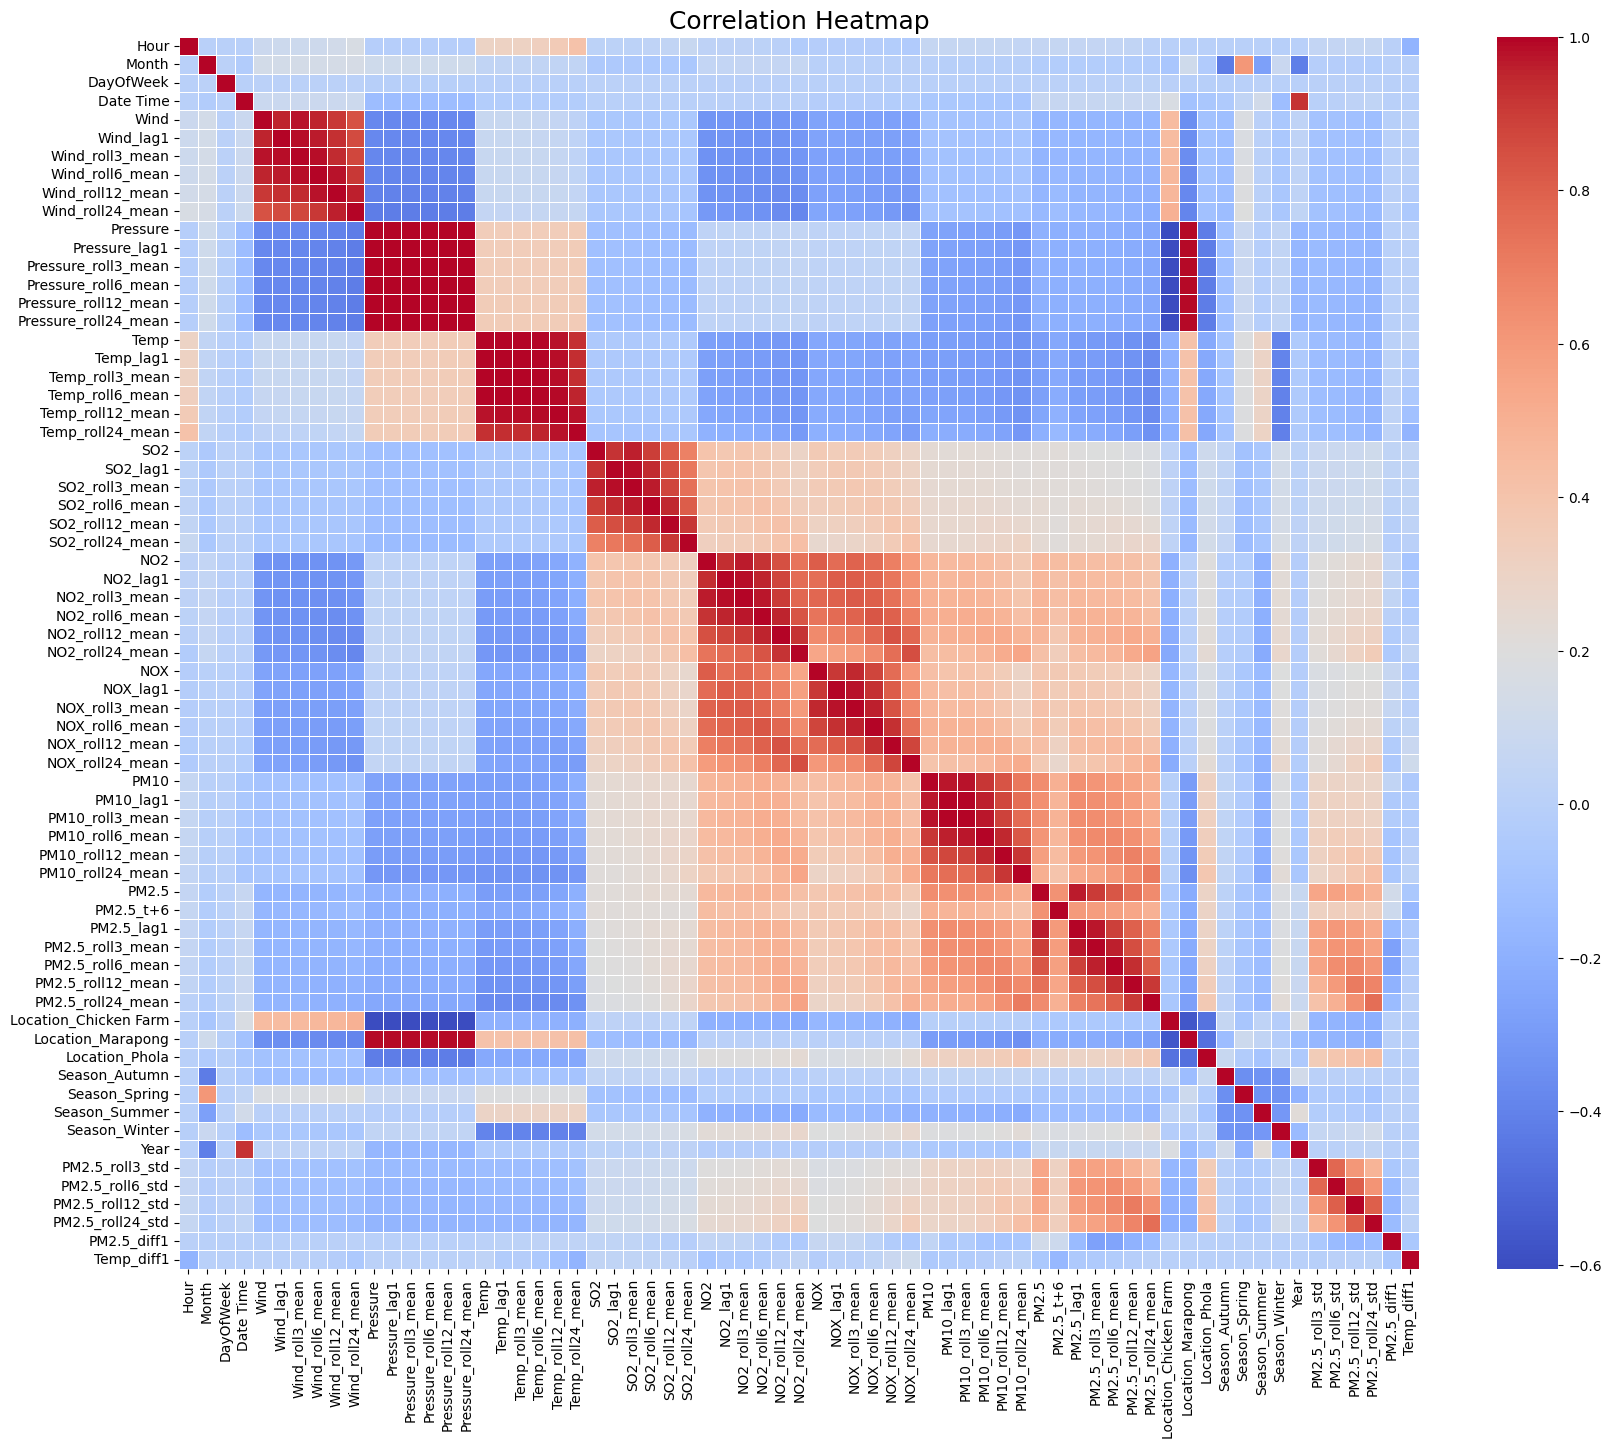

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data_for_model.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Generate a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Heatmap', fontsize=18)
plt.show()


In [10]:
# Compute correlations with the target
target = 'PM2.5_t+6'
correlations = data_for_model.corr()[target].drop(target)

# Sort by absolute correlation (strongest relationships first)
feature_ranking = correlations.abs().sort_values(ascending=False)

# Display top 15 features most correlated with PM2.5_t+12
print("Top correlated features with PM2.5_t+12:\n")
print(feature_ranking.head(20))

Top correlated features with PM2.5_t+12:

PM2.5                0.626256
PM2.5_lag1           0.596650
PM2.5_roll3_mean     0.581426
PM2.5_roll6_mean     0.568634
PM2.5_roll12_mean    0.544095
PM10                 0.500914
PM2.5_roll24_mean    0.497677
PM10_roll3_mean      0.486015
PM10_lag1            0.478089
PM10_roll6_mean      0.470021
PM10_roll12_mean     0.442070
NO2                  0.438188
NO2_roll3_mean       0.430998
NO2_lag1             0.418649
NO2_roll6_mean       0.415151
PM10_roll24_mean     0.400346
NO2_roll12_mean      0.384184
NOX                  0.372720
NOX_roll3_mean       0.366028
NOX_lag1             0.350953
Name: PM2.5_t+6, dtype: float64


In [11]:
feature_ranking

PM2.5                    0.626256
PM2.5_lag1               0.596650
PM2.5_roll3_mean         0.581426
PM2.5_roll6_mean         0.568634
PM2.5_roll12_mean        0.544095
                           ...   
Hour                     0.064957
Location_Chicken Farm    0.055870
Season_Autumn            0.022493
Month                    0.022395
DayOfWeek                0.010218
Name: PM2.5_t+6, Length: 66, dtype: float64

In [12]:
data_for_model

,Hour,Month,DayOfWeek,Date Time,Wind,Wind_lag1,Wind_roll3_mean,Wind_roll6_mean,Wind_roll12_mean,Wind_roll24_mean,Pressure,Pressure_lag1,Pressure_roll3_mean,Pressure_roll6_mean,Pressure_roll12_mean,Pressure_roll24_mean,Temp,Temp_lag1,Temp_roll3_mean,Temp_roll6_mean,Temp_roll12_mean,Temp_roll24_mean,SO2,SO2_lag1,SO2_roll3_mean,SO2_roll6_mean,SO2_roll12_mean,SO2_roll24_mean,NO2,NO2_lag1,NO2_roll3_mean,NO2_roll6_mean,NO2_roll12_mean,NO2_roll24_mean,NOX,NOX_lag1,NOX_roll3_mean,NOX_roll6_mean,NOX_roll12_mean,NOX_roll24_mean,PM10,PM10_lag1,PM10_roll3_mean,PM10_roll6_mean,PM10_roll12_mean,PM10_roll24_mean,PM2.5,PM2.5_t+6,PM2.5_lag1,PM2.5_roll3_mean,PM2.5_roll6_mean,PM2.5_roll12_mean,PM2.5_roll24_mean,Location_Chicken Farm,Location_Marapong,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Year,PM2.5_roll3_std,PM2.5_roll6_std,PM2.5_roll12_std,PM2.5_roll24_std,PM2.5_diff1,Temp_diff1
0,20,1,4,2016-01-15 20:10:00,5.013026,6.535129,5.808405,5.669708,5.005227,5.390149,846.0,846.0,846.000000,846.000000,846.000000,845.250000,17.53,17.60,17.676667,17.860000,17.685000,19.031250,8.150,12.060,13.016667,12.320000,10.885000,10.724625,1.122,0.853,1.010000,1.036167,1.202667,1.286875,4.242,7.925,7.695667,7.931333,7.243500,7.783167,27.390,57.750,53.926667,81.613333,88.217500,102.378750,13.810,22.230,31.680,41.970000,49.580000,54.111667,48.655417,True,False,False,False,False,True,False,2016,9.321658,10.283982,9.550991,10.983233,-17.870,-0.07
1,20,1,4,2016-01-15 20:20:00,4.576110,5.013026,5.374755,5.538088,5.002518,5.333207,847.0,846.0,846.333333,846.166667,846.083333,845.375000,17.48,17.53,17.536667,17.763333,17.725833,18.818750,9.410,8.150,9.873333,12.226667,10.988333,10.260042,1.257,1.122,1.077333,1.043667,1.193333,1.290625,6.268,4.242,6.145000,7.707500,7.337667,7.307250,6.130,27.390,30.423333,63.201667,82.490000,97.188333,4.857,16.570,13.810,29.956667,42.018333,51.283333,46.873750,True,False,False,False,False,True,False,2016,15.357690,16.571430,15.048998,12.937813,-8.953,-0.05
2,20,1,4,2016-01-15 20:30:00,5.604620,4.576110,5.064585,5.558342,5.178374,5.294307,847.0,847.0,846.666667,846.333333,846.166667,845.541667,17.56,17.48,17.523333,17.676667,17.747500,18.598750,9.590,9.410,9.050000,12.028333,11.012500,9.941292,1.324,1.257,1.234333,1.084833,1.189583,1.295292,9.060,6.268,6.523333,7.870833,7.486333,7.157250,4.019,6.130,12.513000,45.054833,76.335750,91.468292,4.540,12.030,4.857,16.782333,33.312833,47.258917,45.122375,True,False,False,False,False,True,False,2016,13.656295,20.357587,20.110523,15.522344,-0.317,0.08
3,20,1,4,2016-01-15 20:40:00,4.630336,5.604620,4.937022,5.372713,5.245980,5.189059,847.0,847.0,847.000000,846.500000,846.250000,845.666667,17.61,17.56,17.550000,17.613333,17.755833,18.402500,8.640,9.590,9.213333,11.115000,10.946667,9.725875,1.324,1.324,1.301667,1.155833,1.215750,1.295292,7.332,9.060,7.553333,7.624500,7.489167,7.007750,4.064,4.019,4.737667,29.332167,69.607750,85.550125,7.338,8.160,4.540,7.735667,24.852833,42.430583,43.161542,True,False,False,False,False,True,False,2016,5.262914,19.935734,22.887542,17.513206,2.798,0.05
4,20,1,4,2016-01-15 20:50:00,4.861779,4.630336,5.032245,5.203500,5.324203,5.126829,847.0,847.0,847.000000,846.666667,846.333333,845.791667,17.63,17.61,17.600000,17.568333,17.756667,18.222917,7.702,8.640,8.644000,9.258667,10.811833,9.631375,1.773,1.324,1.473667,1.275500,1.185750,1.314917,5.294,7.332,7.228667,6.686833,7.376250,6.669167,4.042,4.064,4.041667,17.232500,61.644583,79.618542,19.630,5.870,7.338,5.578333,17.767500,37.577083,41.248542,True,False,False,False,False,True,False,2016,1.532137,16.540054,23.693405,18.821940,12.292,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289473,22,12,0,2017-12-11 22:50:00,1.579270,1.871147,1.752186,1.720526,1.709215,2.079104,847.

In [13]:
features = [
    "PM2.5",
    "PM2.5_lag1",
    "PM2.5_roll3_mean",
    "PM2.5_roll6_mean",
    "PM2.5_roll12_mean",
    "PM10",
    "PM2.5_roll24_mean",
    "PM10_roll3_mean",
    "PM10_lag1",
    "PM10_roll6_mean",
    "PM10_roll12_mean",
    "NO2",
    "NO2_roll3_mean",
    "NO2_lag1",
    "NO2_roll6_mean",
    "PM10_roll24_mean",
    "NO2_roll12_mean",
]


In [14]:
# data_for_model = data_for_model.dropna()
# data_for_model.drop(columns=['PM2.5_lag1', 'PM2.5_roll3_mean', 'PM2.5_roll6_mean',
#        'PM2.5_roll12_mean', 'PM2.5_roll24_mean'], inplace=True)

# data_for_model

In [15]:
X = data_for_model[features]
y = data_for_model['PM2.5_t+6']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [16]:
X

,PM2.5,PM2.5_lag1,PM2.5_roll3_mean,PM2.5_roll6_mean,PM2.5_roll12_mean,PM10,PM2.5_roll24_mean,PM10_roll3_mean,PM10_lag1,PM10_roll6_mean,PM10_roll12_mean,NO2,NO2_roll3_mean,NO2_lag1,NO2_roll6_mean,PM10_roll24_mean,NO2_roll12_mean
0,13.810,31.680,41.970000,49.580000,54.111667,27.390,48.655417,53.926667,57.750,81.613333,88.217500,1.122,1.010000,0.853,1.036167,102.378750,1.202667
1,4.857,13.810,29.956667,42.018333,51.283333,6.130,46.873750,30.423333,27.390,63.201667,82.490000,1.257,1.077333,1.122,1.043667,97.188333,1.193333
2,4.540,4.857,16.782333,33.312833,47.258917,4.019,45.122375,12.513000,6.130,45.054833,76.335750,1.324,1.234333,1.257,1.084833,91.468292,1.189583
3,7.338,4.540,7.735667,24.852833,42.430583,4.064,43.161542,4.737667,4.019,29.332167,69.607750,1.324,1.301667,1.324,1.155833,85.550125,1.215750
4,19.630,7.338,5.578333,17.767500,37.577083,4.042,41.248542,4.041667,4.064,17.232500,61.644583,1.773,1.473667,1.324,1.275500,79.618542,1.185750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289473,24.660,34.900,53.970000,64.996667,51.169167,19.250,49.799167,24.020000,22.450,25.358333,37.663333,2.377,2.580000,2.535,2.865500,40.919167,2.970667
289474,15.620,24.660,37.500000,58.071667,48.290000,15.410,48.068333,19.036667,19.250,23.353333,33.260833,2.321,2.411000,2.377,2.670167,39.832917,2.910583
289475,12.350,15.620,25.060000,47.498333,46.880000,14.870,46.241667,16.510000,15.410,21.420000,29.080833,2.456,2.384667,2.321,2.557500,38.557083,2.843917
289476,3.836,12.350,17.543333,35.756667,46.183333,14.540,45.237917,14.940000,14.870,19.480000,25.494167,2.479,2.418667,2.456,2.499333,37.439583,2.802583


In [17]:
# Let's use 80% of the data for training, 20% for testing
split_idx = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [18]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/50


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7237/7237 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 380.0844 - val_loss: 1175.2946
Epoch 2/50
7237/7237 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 303.0852 - val_loss: 1177.2721
Epoch 3/50
7237/7237 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 301.4411 - val_loss: 1164.9226
Epoch 4/50
7237/7237 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 293.5034 - val_loss: 1173.2882
Epoch 5/50
7237/7237 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 298.6856 - val_loss: 1162.4928
Epoch 6/50
7237/7237 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 288.1568 - val_loss: 1169.8500
Epoch 7/50
7237/7237 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 297.5437 - val_loss: 1158.0214
Epoch 8/50
7237/7237 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 283.8777 - val_loss: 1170.6619
Epoch 9/50
7237/7237 ━━━━━━━━━━━━━━━━━━━━ 7s 984us/step - loss: 281.4623 - val_loss: 1158.2977
Epoch 10/50
7237/7237 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 294.1564 - val_loss: 1165.9227
Epoch 11/50
7237/7237 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 288.9388 - val_

In [19]:
y_pred = model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")


1810/1810 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step
R²: 0.36605621294093926
RMSE: 34.019474251737996


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
last_known_data = data_for_model.iloc[-1][features].values.reshape(1, -1)
last_known_data_scaled = scaler.transform(last_known_data)

forecast_24hr = model.predict(last_known_data_scaled)[0][0]
print(f"Forecasted PM2.5 (24 hrs ahead): {forecast_24hr}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Forecasted PM2.5 (24 hrs ahead): 18.248958587646484


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


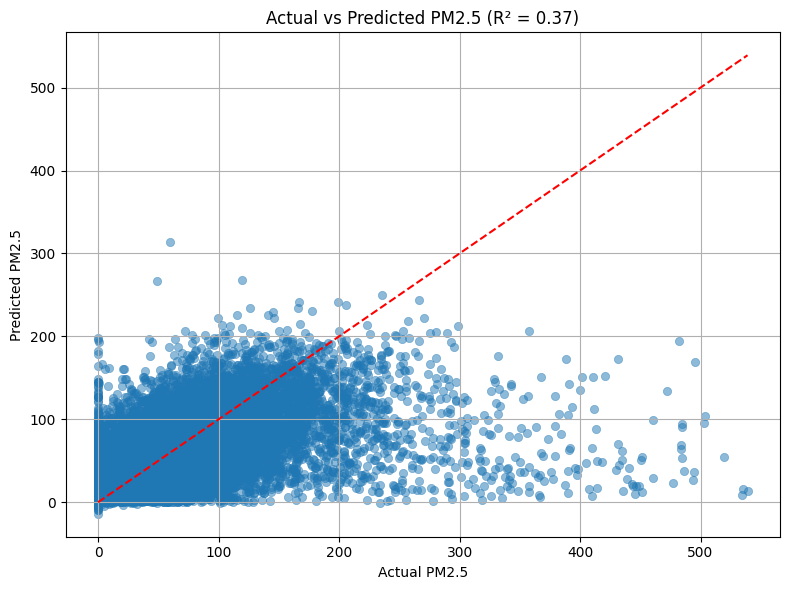

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Assuming y_test and y_pred are already inverse transformed to the original scale
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Actual vs Predicted PM2.5 (R² = {r2_score(y_test, y_pred):.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()


# Testing out XGBoost Regressor and Random Forrest Regressor

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

features = [
    'PM2.5', 'PM2.5_lag1', 'PM2.5_roll3_mean', 'PM2.5_roll6_mean', 'PM2.5_roll12_mean',
    'PM10', 'PM2.5_roll24_mean', 'PM10_roll3_mean', 'PM10_lag1', 'PM10_roll6_mean',
    'PM10_roll12_mean', 'NO2', 'NO2_roll3_mean', 'NO2_lag1', 'NO2_roll6_mean',
    'PM10_roll24_mean', 'NO2_roll12_mean'
]

X = data_for_model.drop(columns=['PM2.5_t+6', 'Date Time'])
y = data_for_model['PM2.5_t+6']

In [35]:
X

,Hour,Month,DayOfWeek,Wind,Wind_lag1,Wind_roll3_mean,Wind_roll6_mean,Wind_roll12_mean,Wind_roll24_mean,Pressure,Pressure_lag1,Pressure_roll3_mean,Pressure_roll6_mean,Pressure_roll12_mean,Pressure_roll24_mean,Temp,Temp_lag1,Temp_roll3_mean,Temp_roll6_mean,Temp_roll12_mean,Temp_roll24_mean,SO2,SO2_lag1,SO2_roll3_mean,SO2_roll6_mean,SO2_roll12_mean,SO2_roll24_mean,NO2,NO2_lag1,NO2_roll3_mean,NO2_roll6_mean,NO2_roll12_mean,NO2_roll24_mean,NOX,NOX_lag1,NOX_roll3_mean,NOX_roll6_mean,NOX_roll12_mean,NOX_roll24_mean,PM10,PM10_lag1,PM10_roll3_mean,PM10_roll6_mean,PM10_roll12_mean,PM10_roll24_mean,PM2.5,PM2.5_lag1,PM2.5_roll3_mean,PM2.5_roll6_mean,PM2.5_roll12_mean,PM2.5_roll24_mean,Location_Chicken Farm,Location_Marapong,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Year,PM2.5_roll3_std,PM2.5_roll6_std,PM2.5_roll12_std,PM2.5_roll24_std,PM2.5_diff1,Temp_diff1
0,20,1,4,5.013026,6.535129,5.808405,5.669708,5.005227,5.390149,846.0,846.0,846.000000,846.000000,846.000000,845.250000,17.53,17.60,17.676667,17.860000,17.685000,19.031250,8.150,12.060,13.016667,12.320000,10.885000,10.724625,1.122,0.853,1.010000,1.036167,1.202667,1.286875,4.242,7.925,7.695667,7.931333,7.243500,7.783167,27.390,57.750,53.926667,81.613333,88.217500,102.378750,13.810,31.680,41.970000,49.580000,54.111667,48.655417,True,False,False,False,False,True,False,2016,9.321658,10.283982,9.550991,10.983233,-17.870,-0.07
1,20,1,4,4.576110,5.013026,5.374755,5.538088,5.002518,5.333207,847.0,846.0,846.333333,846.166667,846.083333,845.375000,17.48,17.53,17.536667,17.763333,17.725833,18.818750,9.410,8.150,9.873333,12.226667,10.988333,10.260042,1.257,1.122,1.077333,1.043667,1.193333,1.290625,6.268,4.242,6.145000,7.707500,7.337667,7.307250,6.130,27.390,30.423333,63.201667,82.490000,97.188333,4.857,13.810,29.956667,42.018333,51.283333,46.873750,True,False,False,False,False,True,False,2016,15.357690,16.571430,15.048998,12.937813,-8.953,-0.05
2,20,1,4,5.604620,4.576110,5.064585,5.558342,5.178374,5.294307,847.0,847.0,846.666667,846.333333,846.166667,845.541667,17.56,17.48,17.523333,17.676667,17.747500,18.598750,9.590,9.410,9.050000,12.028333,11.012500,9.941292,1.324,1.257,1.234333,1.084833,1.189583,1.295292,9.060,6.268,6.523333,7.870833,7.486333,7.157250,4.019,6.130,12.513000,45.054833,76.335750,91.468292,4.540,4.857,16.782333,33.312833,47.258917,45.122375,True,False,False,False,False,True,False,2016,13.656295,20.357587,20.110523,15.522344,-0.317,0.08
3,20,1,4,4.630336,5.604620,4.937022,5.372713,5.245980,5.189059,847.0,847.0,847.000000,846.500000,846.250000,845.666667,17.61,17.56,17.550000,17.613333,17.755833,18.402500,8.640,9.590,9.213333,11.115000,10.946667,9.725875,1.324,1.324,1.301667,1.155833,1.215750,1.295292,7.332,9.060,7.553333,7.624500,7.489167,7.007750,4.064,4.019,4.737667,29.332167,69.607750,85.550125,7.338,4.540,7.735667,24.852833,42.430583,43.161542,True,False,False,False,False,True,False,2016,5.262914,19.935734,22.887542,17.513206,2.798,0.05
4,20,1,4,4.861779,4.630336,5.032245,5.203500,5.324203,5.126829,847.0,847.0,847.000000,846.666667,846.333333,845.791667,17.63,17.61,17.600000,17.568333,17.756667,18.222917,7.702,8.640,8.644000,9.258667,10.811833,9.631375,1.773,1.324,1.473667,1.275500,1.185750,1.314917,5.294,7.332,7.228667,6.686833,7.376250,6.669167,4.042,4.064,4.041667,17.232500,61.644583,79.618542,19.630,7.338,5.578333,17.767500,37.577083,41.248542,True,False,False,False,False,True,False,2016,1.532137,16.540054,23.693405,18.821940,12.292,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289473,22,12,0,1.579270,1.871147,1.752186,1.720526,1.709215,2.079104,847.0,847.0,847.000000,847.000000,847.000000,846.541667,17.38,17.46,17.476667,17.666667,18.008333,18.836667,0.811,0.676,0.784667,0.850500,0.921667,1.187333,2.377,2.535,2.580000,2.865500

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [38]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


In [39]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("R2 Score:", r2_score(y_true, y_pred))

evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)



Random Forest Performance:
MAE: 9.208457894573026
RMSE: 17.135805062062413
R2 Score: 0.6753081671292609

XGBoost Performance:
MAE: 10.521739687316503
RMSE: 18.627330138000165
R2 Score: 0.6163249464753526


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
import matplotlib.pyplot as plt

# For Random Forest
rf_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
rf_importance.plot(kind='bar', title='Random Forest Feature Importance')
plt.tight_layout()
plt.show()

ValueError: Length of values (65) does not match length of index (17)

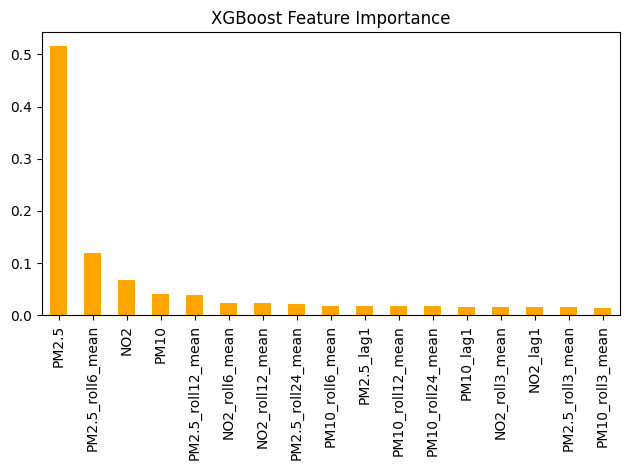

In [ ]:
# For XGBoost
xgb_importance = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)
xgb_importance.plot(kind='bar', title='XGBoost Feature Importance', color='orange')
plt.tight_layout()
plt.show()